# Identificação de biomarcadores

---

### Importações

In [25]:
from funcoes_am import *

### Definições

In [26]:
TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 24
PSEUDOCOUNT = 1

### *Batch Effects*

Utilizou-se a biblioteca ```MMUPHin```. O arquivo ```batch-effect-correction.r``` contém a implementação desse algortimo em R.

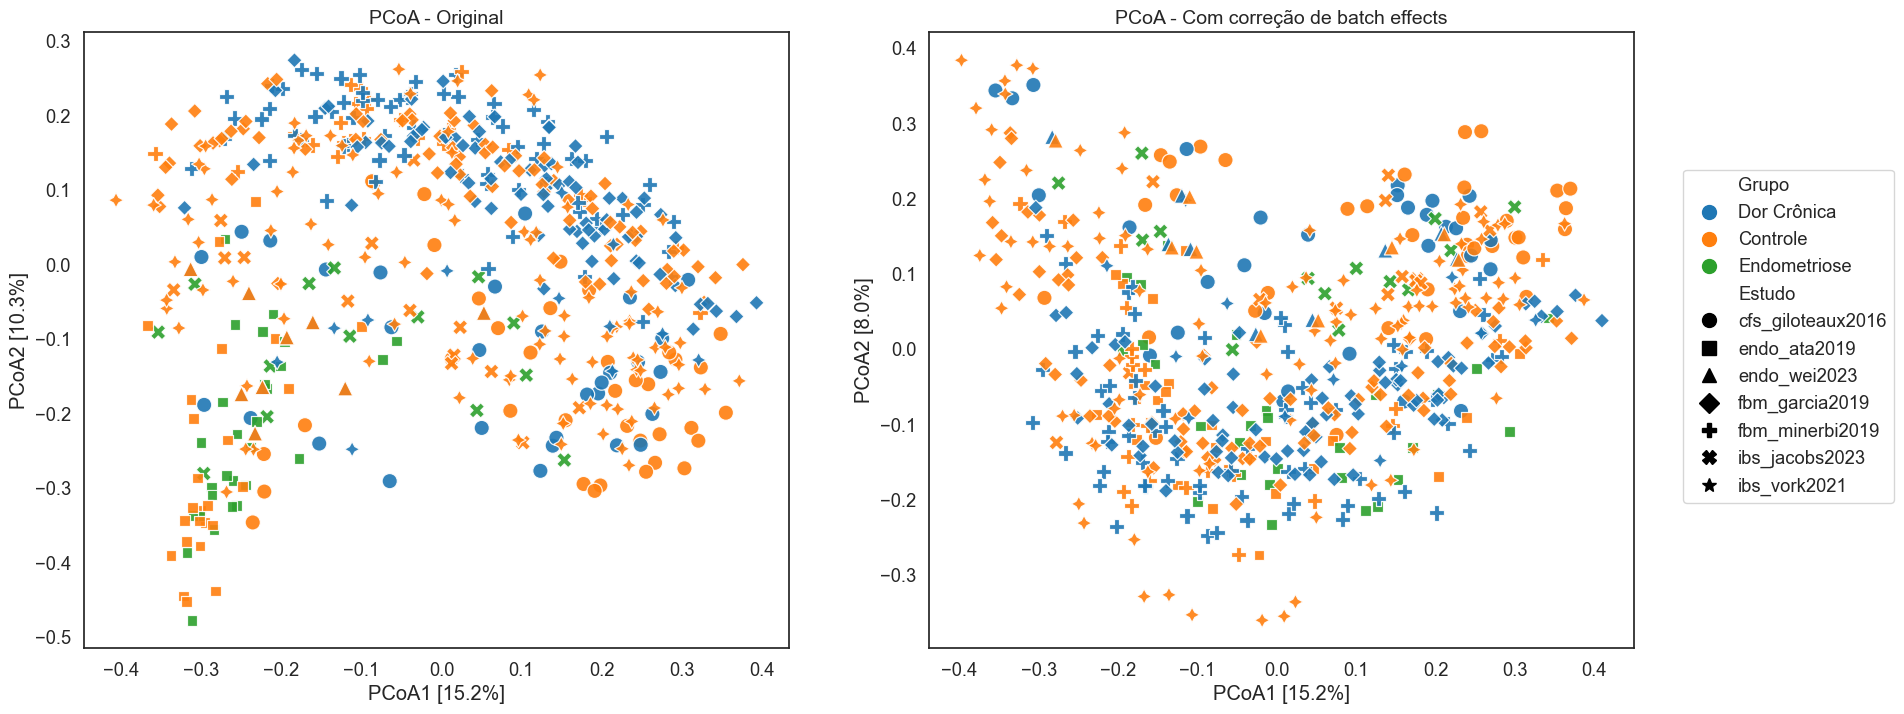

In [44]:
pcoa_comparativa('meta-analise-int-agrupada')

## Meta-análise intestinal agrupada

In [28]:
data = pd.read_csv('taxonomia_meta-analise-int-agrupada_ajustada.csv')
data = data.rename({'Unnamed: 0': 'index'}, axis=1)
data = data.set_index('index')

metadata = pd.read_csv('meta-analise-int-agrupada_metadata.tsv', sep='\t')
metadata = metadata.set_index("sample-id")

data["Condição"] = metadata.loc[data.index, "group"]

In [29]:
X = data.drop(columns=['Condição']).values

le = LabelEncoder()
y = le.fit_transform(data["Condição"])

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA)

### Normalizações

$$\text{clr}(x) = \left[\log \frac{x_1}{g(X)}, \dots, \log \frac{x_D}{g(x)}\right],$$

em que $g(x)$ é a média geométrica de $x$ e $D$ é o número de componentes.

In [30]:
# X_treino_clr = clr(X_treino + PSEUDOCOUNT) 
# X_teste_clr  = clr(X_teste  + PSEUDOCOUNT)

# normalizador = StandardScaler()
# X_treino_norm = normalizador.fit_transform(X_treino)
# X_teste_norm = normalizador.transform(X_teste)

print(dict(zip(le.classes_, range(len(le.classes_)))))

{'Controle': 0, 'Dor Crônica': 1, 'Endometriose': 2}


---

**Nota:** Ainda será feita uma seleção inicial de *features* e os modelos implementados serão otimizados.

### Regressão Logística

In [31]:
modelo_RL = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, C=0.1, class_weight='balanced')

modelo_RL.fit(X_treino, y_treino) 

LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000, penalty='l1',
                   solver='saga')

In [32]:
y_pred_RL = modelo_RL.predict(X_teste) 
y_proba_RL = modelo_RL.predict_proba(X_teste)

print("Modelo: RL\n")
print(f"Acurácia: {accuracy_score(y_teste, y_pred_RL):.3f}" ) 
print(f"ROC AUC: {roc_auc_score(y_teste, y_proba_RL, multi_class='ovr'):.3f}")
print("\nRelatório de classificação:\n", classification_report(y_teste, y_pred_RL, target_names=le.classes_))
print("\nMatriz de confusão:\n", confusion_matrix(y_teste, y_pred_RL))

Modelo: RL

Acurácia: 0.585
ROC AUC: 0.753

Relatório de classificação:
               precision    recall  f1-score   support

    Controle       0.70      0.53      0.60        30
 Dor Crônica       0.50      0.56      0.53        18
Endometriose       0.50      1.00      0.67         5

    accuracy                           0.58        53
   macro avg       0.57      0.70      0.60        53
weighted avg       0.61      0.58      0.58        53


Matriz de confusão:
 [[16 10  4]
 [ 7 10  1]
 [ 0  0  5]]


### Floresta Aleatória

In [45]:
modelo_RF = RandomForestClassifier(n_estimators=500, random_state=SEMENTE_ALEATORIA, class_weight='balanced')

modelo_RF.fit(X_treino, y_treino)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=24)

In [48]:
y_pred_RF = modelo_RF.predict(X_teste) 

print("Modelo: RF\n")
print(f"Acurácia: {accuracy_score(y_teste, y_pred_RF):.3f}" ) 
print("\nRelatório de classificação:\n", classification_report(y_teste, y_pred_RF, target_names=le.classes_))
print("\nMatriz de confusão:\n", confusion_matrix(y_teste, y_pred_RF))

Modelo: RF

Acurácia: 0.585

Relatório de classificação:
               precision    recall  f1-score   support

    Controle       0.60      0.80      0.69        30
 Dor Crônica       0.54      0.39      0.45        18
Endometriose       0.00      0.00      0.00         5

    accuracy                           0.58        53
   macro avg       0.38      0.40      0.38        53
weighted avg       0.52      0.58      0.54        53


Matriz de confusão:
 [[24  6  0]
 [11  7  0]
 [ 5  0  0]]


c:\venv\ilumpy\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\venv\ilumpy\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\venv\ilumpy\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Explainable Boosting Machine (EBM)

In [39]:
pesos = compute_sample_weight(class_weight='balanced', y=y_treino)

modelo_EBM = ExplainableBoostingClassifier(random_state=SEMENTE_ALEATORIA, interactions=0)
modelo_EBM.fit(X_treino, y_treino, sample_weight=pesos)

ExplainableBoostingClassifier(interactions=0, random_state=24)

In [40]:
y_pred_EBM = modelo_EBM.predict(X_teste)

acuracia_EBM = accuracy_score(y_teste, y_pred_EBM) 

print("Modelo: EBM\n")
print(f"Acurácia: {acuracia_EBM:.3f}" ) 
print("\nRelatório de classificação:\n", classification_report(y_teste, y_pred_EBM, target_names=le.classes_))
print("\nMatriz de confusão:\n", confusion_matrix(y_teste, y_pred_EBM))

Modelo: EBM

Acurácia: 0.585

Relatório de classificação:
               precision    recall  f1-score   support

    Controle       0.66      0.63      0.64        30
 Dor Crônica       0.45      0.50      0.47        18
Endometriose       0.75      0.60      0.67         5

    accuracy                           0.58        53
   macro avg       0.62      0.58      0.59        53
weighted avg       0.59      0.58      0.59        53


Matriz de confusão:
 [[19 10  1]
 [ 9  9  0]
 [ 1  1  3]]
